## The Components:

- **Query ($Q$):** What I am looking for. (e.g., "The cat sat on the...")
- **Key ($K$):** The label or "tag" of the information stored. (e.g., "mat")
- **Value ($V$):** The actual content/information. (e.g., The vector embedding for "mat")

## The Process:

1. **Similarity:** Compare $Q$ with every $K$ (Dot Product).
2. **Probability:** Turn scores into percentages (Softmax).
3. **Retrieval:** Multiply percentages by $V$.

## The Math

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

- **$QK^T$:** The Dot Product. Measures alignment. High score = High similarity.
- **$\sqrt{d_k}$:** The Scaling Factor. (We will verify why this is needed below).
- **$\text{Softmax}$:** Normalizes scores so they sum to 1.0

## The Linear Projections

Right now, you might think $Q, K, V$ just appear from the input. They don't.

The input to the layer is just a raw embedding vector $x$ (e.g., size 512).

- How does "The" (Input $x$) become a "Query" ($Q$)?
- How does it typically become a "Key" ($K$)?

### The Answer: We train three separate Linear Layers to transform the input.

- **$W_q$ (Query Weight):** "Take the input and extract the searching intent."
- **$W_k$ (Key Weight):** "Take the input and extract the label/tag info."
- **$W_v$ (Value Weight):** "Take the input and extract the content info."

$$Q = x \cdot W_q$$
$$K = x \cdot W_k$$
$$V = x \cdot W_v$$

These weights ($W_q, W_k, W_v$) are what the model actually learns during training.

In [1]:
import torch
import torch.nn.functional as F
import math

def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Computes the scaled dot product attention.
    Args:
        q: Queries (Batch, Heads, Seq_Len_Q, Dim_Head)
        k: Keys    (Batch, Heads, Seq_Len_K, Dim_Head)
        v: Values  (Batch, Heads, Seq_Len_K, Dim_Head)
        mask: Optional mask (e.g., for causal masking)
    """
    d_k = q.size(-1) # Dimension of the key head
    
    # 1. Similarity Scores (Q @ K_transpose)
    # Shape: (Batch, Heads, Seq_Len_Q, Seq_Len_K)
    # We transpose the last two dimensions of K to align for multiplication
    scores = torch.matmul(q, k.transpose(-2, -1))
    
    # 2. Scaling (The Stability Key)
    scores = scores / math.sqrt(d_k)
    
    # 3. Masking (Optional - we will use this later)
    if mask is not None:
        # Replace 0s (masked positions) with -infinity so softmax makes them 0
        scores = scores.masked_fill(mask == 0, -1e9)
    
    # 4. Attention Weights (Softmax)
    # Convert scores to probabilities (0.0 to 1.0)
    attn_weights = F.softmax(scores, dim=-1)
    
    # 5. Weighted Aggregation (Weights @ V)
    output = torch.matmul(attn_weights, v)
    
    return output, attn_weights

# --- VERIFICATION LAB ---
def verify_attention():
    print("--- 2.1 Attention Math Check ---")
    
    # Setup standard dimensions
    batch_size = 1
    heads = 1
    seq_len = 3
    d_k = 4 # Tiny dimension for easy reading
    
    # Create fake data
    # Query: Looking for something specific
    q = torch.randn(batch_size, heads, seq_len, d_k)
    k = torch.randn(batch_size, heads, seq_len, d_k)
    v = torch.randn(batch_size, heads, seq_len, d_k)
    
    output, weights = scaled_dot_product_attention(q, k, v)
    
    print(f"Scores Shape: {weights.shape}")
    print(f"Output Shape: {output.shape}")
    print("\nAttention Weights (Row sum must be 1.0):")
    print(weights[0,0]) 
    print("Row Sum:", weights[0,0].sum(dim=-1))

if __name__ == "__main__":
    verify_attention()

--- 2.1 Attention Math Check ---
Scores Shape: torch.Size([1, 1, 3, 3])
Output Shape: torch.Size([1, 1, 3, 4])

Attention Weights (Row sum must be 1.0):
tensor([[0.2053, 0.3439, 0.4508],
        [0.2956, 0.3737, 0.3308],
        [0.5547, 0.2591, 0.1862]])
Row Sum: tensor([1.0000, 1.0000, 1.0000])


## Why Scaling? (The "Hot" Softmax Problem)

You asked why we divide by $\sqrt{d_k}$. Let's use simple numbers.

### The Softmax Function:

Softmax turns numbers into probabilities.

- **Input:** [2, 1] → **Softmax:** [0.73, 0.27] (Nice, soft mix)
- **Input:** [20, 10] → **Softmax:** [0.99995, 0.00005] (Extreme, hard spike)

### The Problem with High Dimensions:

In deep learning, our vectors are long (e.g., 512 numbers).

When you do a Dot Product of two long vectors, the result is a **Sum**.

$1 \times 1 + 1 \times 1 + ...$ (512 times) = 512.

The numbers get huge just because the vectors are long.

If we feed huge numbers (like 512) into Softmax, it panics. It outputs 1.0 for the winner and 0.0 for everyone else.

**Result:** The model becomes "arrogant." It only looks at one thing and ignores everything else. The gradients die.

### The Fix (Scaling):

We divide the huge number by the square root of the length ($\sqrt{512} \approx 22$).

$512 / 22 \approx 23$. (Still big, but manageable).

Usually, it brings the variance back down to ~1.0.

In [ ]:
def simple_scaling_demo():
    print("--- Why Scaling Matters ---")
    
    # 1. Imagine a Dot Product result (Similarity Scores)
    # Let's say we have 3 keys.
    
    # CASE A: Small numbers (Simulating a small network)
    small_scores = torch.tensor([2.0, 1.0, 0.5])
    print(f"\n1. Small Scores: {small_scores.tolist()}")
    
    # Apply Softmax
    probs_small = F.softmax(small_scores, dim=0)
    print(f"   Softmax Output: {probs_small.tolist()}")
    print("   -> Result: Nice distribution. The model considers all options.")

    # CASE B: Huge numbers (Simulating a real Transformer without scaling)
    # In 512-dim space, dot products naturally become huge (e.g., 50, 100)
    huge_scores = torch.tensor([200.0, 100.0, 50.0])
    print(f"\n2. Huge Scores (Unscaled): {huge_scores.tolist()}")
    
    # Apply Softmax
    probs_huge = F.softmax(huge_scores, dim=0)
    print(f"   Softmax Output: {probs_huge.tolist()}")
    print("   -> Result: [1.0, 0.0, 0.0]. The model is 'arrogant'. Gradient is DEAD.")
    
    # CASE C: The Fix (Scaling)
    # We divide by a factor (let's say 100 to simulate sqrt(d_k))
    scale_factor = 100.0
    scaled_scores = huge_scores / scale_factor
    print(f"\n3. Scaled Scores: {scaled_scores.tolist()}")
    
    # Apply Softmax
    probs_scaled = F.softmax(scaled_scores, dim=0)
    print(f"   Softmax Output: {probs_scaled.tolist()}")
    print("   -> Result: Back to a nice distribution! Gradients can flow.")

if __name__ == "__main__":
    simple_scaling_demo()

--- Why Scaling Matters ---

1. Small Scores: [2.0, 1.0, 0.5]
   Softmax Output: [0.6285316944122314, 0.23122389614582062, 0.14024437963962555]
   -> Result: Nice distribution. The model considers all options.

2. Huge Scores (Unscaled): [200.0, 100.0, 50.0]
   Softmax Output: [1.0, 3.783505853677006e-44, 0.0]
   -> Result: [1.0, 0.0, 0.0]. The model is 'arrogant'. Gradient is DEAD.

3. Scaled Scores: [2.0, 1.0, 0.5]
   Softmax Output: [0.6285316944122314, 0.23122389614582062, 0.14024437963962555]
   -> Result: Back to a nice distribution! Gradients can flow.


## Causal Masking: "No Peeking at the Future"

In a Transformer (like GPT), the model reads the sentence one word at a time. It tries to guess the next word. If it can "peek" at the next word, it learns nothing. It just copies the answer.

We use PyTorch's `tril` (Triangle Lower) function.

**Sentence:** ["The", "cat", "sat"]

We feed this entire list into the GPU at once to be fast. But strictly mathematically, we must enforce these rules:

### Step 1: The model is at "The"
- **Allowed to see:** ["The"]
- **Question:** "What comes next?"
- **Must NOT see:** ["cat", "sat"] (The Future)

### Step 2: The model is at "cat"
- **Allowed to see:** ["The", "cat"] (Past + Present)
- **Question:** "What comes next?"
- **Must NOT see:** ["sat"] (The Future)

### Step 3: The model is at "sat"
- **Allowed to see:** ["The", "cat", "sat"]
- **Question:** "What comes next?" (End of sentence token)

### The Mask Matrix


--- 2.2 The Causal Mask Lab ---

The Binary Mask Template (1=Visible, 0=Future):
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

Probabilities after Softmax (Rows sum to 1):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1411, 0.8589, 0.0000, 0.0000, 0.0000],
        [0.6472, 0.1135, 0.2393, 0.0000, 0.0000],
        [0.2639, 0.1514, 0.4279, 0.1569, 0.0000],
        [0.2700, 0.2259, 0.3631, 0.0275, 0.1135]])


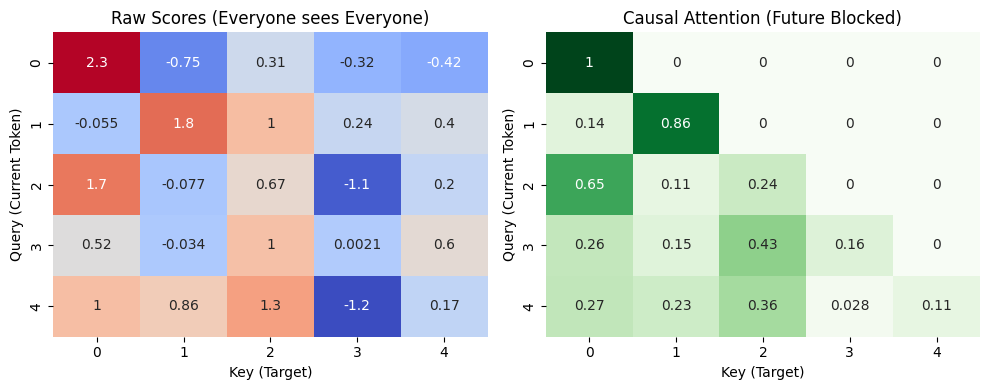

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

def causal_mask_lab():
    print("--- 2.2 The Causal Mask Lab ---")
    
    # 1. Setup
    seq_len = 5
    # Batch=1, Heads=1, Seq=5, Seq=5
    # Simulating raw attention scores (before Softmax)
    scores = torch.randn(1, 1, seq_len, seq_len)
    
    # 2. Create the Mask (The Template)
    # torch.tril returns the lower triangle (1s) and zeros elsewhere
    # We create a matrix of 1s first
    mask = torch.tril(torch.ones(seq_len, seq_len))
    
    print("\nThe Binary Mask Template (1=Visible, 0=Future):")
    print(mask)
    
    # 3. Apply the Mask (The "Fill" Trick)
    # Where mask is 0 (Future), replace score with -1e9 (Negative Infinity)
    # We use -1e9 instead of float('-inf') for numerical stability
    masked_scores = scores.masked_fill(mask == 0, -1e9)
    
    # 4. Softmax (The Proof)
    probs = F.softmax(masked_scores, dim=-1)
    
    print("\nProbabilities after Softmax (Rows sum to 1):")
    print(probs[0,0])
    
    # --- Visualization ---
    plt.figure(figsize=(10, 4))
    
    # Plot 1: The Raw Scores (Chaos)
    plt.subplot(1, 2, 1)
    sns.heatmap(scores[0,0], annot=True, cmap="coolwarm", cbar=False)
    plt.title("Raw Scores (Everyone sees Everyone)")
    plt.xlabel("Key (Target)")
    plt.ylabel("Query (Current Token)")
    
    # Plot 2: The Masked Probabilities (Order)
    plt.subplot(1, 2, 2)
    sns.heatmap(probs[0,0], annot=True, cmap="Greens", cbar=False)
    plt.title("Causal Attention (Future Blocked)")
    plt.xlabel("Key (Target)")
    plt.ylabel("Query (Current Token)")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    causal_mask_lab()

## The Complete Single Head Architecture

Let's assemble the full "Cylinder" before we build the V8 engine.

**The Flow:**

1. **Input:** Batch of token embeddings.
2. **Projections:** Pass through 3 Linear Layers to get Q, K, V.
3. **Attention Core:**
   - Dot Product ($QK^T$)
   - Scale ($1/\sqrt{d}$)
   - Mask (Hide Future)
   - Softmax (Probability)
   - Multiply by $V$
4. **Output:** The weighted sum.

```

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DebugSingleHeadAttention(nn.Module):
    def __init__(self, input_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        
        # Linear Layers
        self.w_q = nn.Linear(input_dim, head_dim, bias=False)
        self.w_k = nn.Linear(input_dim, head_dim, bias=False)
        self.w_v = nn.Linear(input_dim, head_dim, bias=False)
        
        # Dropout (The standard missed component)
        self.dropout = nn.Dropout(0.1) 

    def forward(self, x):
        B, T, C = x.shape
        
        # 1. Projections
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        
        print(f"\n[Step 1] Projecting Input -> Q, K, V")
        print(f"Token 2 Query Vector (First 5 vals): {q[0, 2, :5].detach().tolist()}")
        print(f"Token 2 Key Vector   (First 5 vals): {k[0, 2, :5].detach().tolist()}")
        
        # 2. Raw Scores
        scores = torch.matmul(q, k.transpose(-2, -1))
        print(f"\n[Step 2] Raw Similarity Scores for Token 2 (Before Scaling):")
        print(f"How much Token 2 likes [0, 1, 2, 3, 4]:")
        print(scores[0, 2].detach().tolist())
        
        # 3. Scaling
        scores = scores / math.sqrt(self.head_dim)
        print(f"\n[Step 3] Scaled Scores (Divided by 8):")
        print(scores[0, 2].detach().tolist())
        
        # 4. Masking
        mask = torch.tril(torch.ones(T, T)).to(x.device)
        scores = scores.masked_fill(mask == 0, float('-inf'))
        print(f"\n[Step 4] Masked Scores (Future should be -inf):")
        print(scores[0, 2].detach().tolist())
        
        # 5. Softmax
        attn_weights = F.softmax(scores, dim=-1)
        print(f"\n[Step 5] Probabilities (Softmax):")
        print(f"Notice indices 3 and 4 are now EXACTLY 0.0:")
        print(attn_weights[0, 2].detach().tolist())
        
        # 6. Dropout
        # (We disable this for printing so numbers don't vanish randomly, 
        # but in training, it zeros out 10% of these probs)
        # attn_weights = self.dropout(attn_weights)
        
        # 7. Weighted Sum
        output = torch.matmul(attn_weights, v)
        print(f"\n[Step 6] Final Output for Token 2 (Weighted Sum of V):")
        print(f"First 5 vals: {output[0, 2, :5].detach().tolist()}")
        
        return output

# --- RUN THE TRACE ---
if __name__ == "__main__":
    torch.manual_seed(42) # Fixed random numbers so we see the same thing
    
    input_dim = 16  # Keep it small to be readable
    head_dim = 64
    seq_len = 5
    
    # Fake Input
    x = torch.randn(1, seq_len, input_dim)
    
    model = DebugSingleHeadAttention(input_dim, head_dim)
    output = model(x)


[Step 1] Projecting Input -> Q, K, V
Token 2 Query Vector (First 5 vals): [1.1159005165100098, -0.8813031315803528, 0.3134336471557617, -0.9025377631187439, 0.3396030366420746]
Token 2 Key Vector   (First 5 vals): [0.8562676906585693, -0.6299651861190796, -0.011839349754154682, 0.42453229427337646, 0.35250216722488403]

[Step 2] Raw Similarity Scores for Token 2 (Before Scaling):
How much Token 2 likes [0, 1, 2, 3, 4]:
[1.2321031093597412, -0.7464397549629211, 1.2467565536499023, -0.16716670989990234, -5.537720680236816]

[Step 3] Scaled Scores (Divided by 8):
[0.15401288866996765, -0.09330496937036514, 0.1558445692062378, -0.020895838737487793, -0.692215085029602]

[Step 4] Masked Scores (Future should be -inf):
[0.15401288866996765, -0.09330496937036514, 0.1558445692062378, -inf, -inf]

[Step 5] Probabilities (Softmax):
Notice indices 3 and 4 are now EXACTLY 0.0:
[0.35935986042022705, 0.28062140941619873, 0.36001870036125183, 0.0, 0.0]

[Step 6] Final Output for Token 2 (Weighted Su

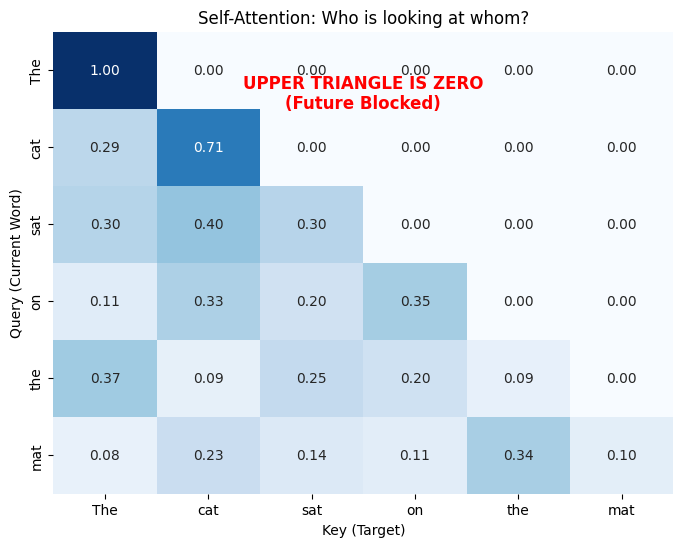

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Setup ---
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, head_dim):
        super().__init__()
        self.head_dim = head_dim
        self.w_q = nn.Linear(input_dim, head_dim, bias=False)
        self.w_k = nn.Linear(input_dim, head_dim, bias=False)
        self.w_v = nn.Linear(input_dim, head_dim, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)
        
        # Calculate Scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        # Apply Causal Mask
        mask = torch.tril(torch.ones(T, T))
        scores = scores.masked_fill(mask == 0, float('-inf'))
        
        # Softmax
        attn_weights = F.softmax(scores, dim=-1)
        return attn_weights

def visualize_real_sentence():
    # 2. The Data
    sentence = ["The", "cat", "sat", "on", "the", "mat"]
    
    # We create a simple "Embedding Table" manually
    # Let's say our embedding dimension is 16
    vocab = {word: i for i, word in enumerate(sentence)}
    embed_dim = 16
    embedding_layer = nn.Embedding(len(vocab), embed_dim)
    
    # Convert words to IDs -> Vectors
    ids = torch.tensor([vocab[w] for w in sentence]).unsqueeze(0) # Batch size 1
    input_vectors = embedding_layer(ids) # Shape: (1, 6, 16)
    
    # 3. The Model
    head_dim = 8
    model = SingleHeadAttention(embed_dim, head_dim)
    
    # 4. Run Forward Pass
    # We get the (6x6) attention matrix
    # Detach removes it from the gradient graph so we can plot it
    attn_matrix = model(input_vectors)[0].detach() 
    
    # 5. Visualization (The "Real" View)
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_matrix, 
                annot=True, # Show the numbers
                fmt=".2f",  # 2 decimal places
                xticklabels=sentence, 
                yticklabels=sentence, 
                cmap="Blues", 
                cbar=False)
    
    plt.title("Self-Attention: Who is looking at whom?")
    plt.xlabel("Key (Target)")
    plt.ylabel("Query (Current Word)")
    
    # Add the "No Peeking" rule explanation
    plt.text(3, 1, "UPPER TRIANGLE IS ZERO\n(Future Blocked)", 
             color='red', fontsize=12, fontweight='bold', ha='center')

    plt.show()

if __name__ == "__main__":
    torch.manual_seed(42) # Consistent random weights
    visualize_real_sentence()